In [126]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [127]:
# loading the csv data set from local directory
OECD = pd.read_csv('OECD_DATA.csv'); OECD = OECD.set_index('Date')
OECD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2399 entries, 11/1/1999 to 9/1/2019
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      2399 non-null   object 
 1   realGdpRate  2399 non-null   float64
 2   realPersInc  2399 non-null   float64
 3   unempRate    2399 non-null   float64
 4   indProd      2399 non-null   float64
 5   retailSales  2399 non-null   float64
dtypes: float64(5), object(1)
memory usage: 131.2+ KB


In [128]:
OECD.head()

,Country,realGdpRate,realPersInc,unempRate,indProd,retailSales
Date,,,,,,
11/1/1999,USA,0.000988,120.886465,0.041,89.75,85.8164
12/1/1999,USA,0.000691,120.702974,0.040,90.44,87.4060
1/1/2000,USA,0.000592,120.649898,0.040,90.46,86.4326
2/1/2000,USA,0.000591,120.657155,0.041,90.73,87.3692
3/1/2000,USA,0.000690,120.614413,0.040,91.05,87.8100


In [129]:
# Standardizing ONLY the numerical features
FEATURES = ['realPersInc', 'unempRate', 'indProd', 'retailSales']
OECD.loc[:, FEATURES] = scale(OECD.loc[:,FEATURES])

In [130]:
OECD.head()

,Country,realGdpRate,realPersInc,unempRate,indProd,retailSales
Date,,,,,,
11/1/1999,USA,0.000988,1.796302,-0.821803,-0.808932,-0.384360
12/1/1999,USA,0.000691,1.775151,-0.871149,-0.748722,-0.286125
1/1/2000,USA,0.000592,1.769032,-0.871149,-0.746977,-0.346280
2/1/2000,USA,0.000591,1.769869,-0.821803,-0.723416,-0.288399
3/1/2000,USA,0.000690,1.764942,-0.871149,-0.695493,-0.261159


In [131]:
# declaring dummy variables based on the Country column
OECD = pd.get_dummies(data=OECD, drop_first=True)
# display top rows of the new data set
OECD.head()

,realGdpRate,realPersInc,unempRate,indProd,retailSales,Country_Denmark,Country_France,Country_Germany,Country_Japan,Country_Korea,Country_Luxembourg,Country_Netherlands,Country_UK,Country_USA
Date,,,,,,,,,,,,,,
11/1/1999,0.000988,1.796302,-0.821803,-0.808932,-0.384360,False,False,False,False,False,False,False,False,True
12/1/1999,0.000691,1.775151,-0.871149,-0.748722,-0.286125,False,False,False,False,False,False,False,False,True
1/1/2000,0.000592,1.769032,-0.871149,-0.746977,-0.346280,False,False,False,False,False,False,False,False,True
2/1/2000,0.000591,1.769869,-0.821803,-0.723416,-0.288399,False,False,False,False,False,False,False,False,True
3/1/2000,0.000690,1.764942,-0.871149,-0.695493,-0.261159,False,False,False,False,False,False,False,False,True


In [132]:
# Define the features and the response variable
RESPONSE = 'realGdpRate' # response
FEATURES = OECD.columns[1:] # total features

In [133]:
# Function to remove outlying values that lie > 3 standard deviations away from the mean
def remove_outliers(df, cols, num_std):
    for col in cols:
        colMean = df[col].mean()
        colStd = df[col].std()
        
        df = df[df[col] <= ((num_std * colStd) + colMean)]
        
    return df

In [134]:
NEW_OECD = remove_outliers(OECD, FEATURES, 3)
NEW_OECD.head()
NEW_OECD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2145 entries, 11/1/1999 to 9/1/2019
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   realGdpRate          2145 non-null   float64
 1   realPersInc          2145 non-null   float64
 2   unempRate            2145 non-null   float64
 3   indProd              2145 non-null   float64
 4   retailSales          2145 non-null   float64
 5   Country_Denmark      2145 non-null   bool   
 6   Country_France       2145 non-null   bool   
 7   Country_Germany      2145 non-null   bool   
 8   Country_Japan        2145 non-null   bool   
 9   Country_Korea        2145 non-null   bool   
 10  Country_Luxembourg   2145 non-null   bool   
 11  Country_Netherlands  2145 non-null   bool   
 12  Country_UK           2145 non-null   bool   
 13  Country_USA          2145 non-null   bool   
dtypes: bool(9), float64(5)
memory usage: 183.9+ KB


In [135]:
# Split data into 80% training set and 20% testing set
FEATURES = ['realPersInc', 'unempRate', 'indProd', 'retailSales']
X_train, X_test, y_train, y_test = train_test_split(NEW_OECD.loc[:, FEATURES], NEW_OECD.loc[:, RESPONSE], test_size=0.2, random_state=0)


In [136]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

importances

array([0.26921056, 0.19461586, 0.24954039, 0.28663319])

Text(0.5, 0, 'Importance Score')

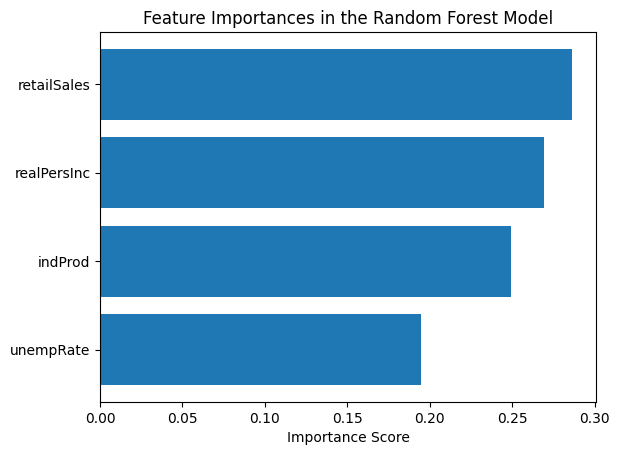

In [137]:
plt.title('Feature Importances in the Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Importance Score')

Text(0.5, 1.0, 'Correlations Between Features')

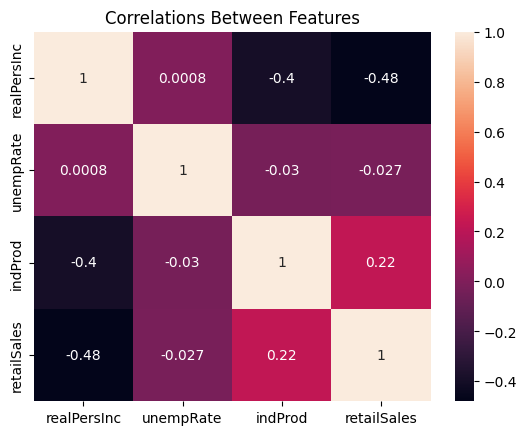

In [138]:
sns.heatmap(OECD.loc[:, FEATURES].corr(), annot=True)
plt.title("Correlations Between Features")

In [139]:
# Compute VIF to identify high correlations b/w features
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({'Features': FEATURES, 'VIF': [variance_inflation_factor(OECD.loc[:, FEATURES].values, i) for i in range(len(FEATURES))]})

,Features,VIF
0,realPersInc,1.466348
1,unempRate,1.001858
2,indProd,1.189037
3,retailSales,1.302709


In [140]:
FEATURES_TO_DROP=[FEATURES[i] for i in range(len(FEATURES)) if variance_inflation_factor(NEW_OECD.loc[:, FEATURES].values, i) >= 5] # features with > 5 VIF
NEW_OECD = NEW_OECD.drop(columns=FEATURES_TO_DROP) 
X_train = X_train.drop(columns = FEATURES_TO_DROP)
X_test = X_test.drop(columns= FEATURES_TO_DROP)
FEATURES = [f for f in FEATURES if f not in FEATURES_TO_DROP]

linear_model = LinearRegression()
linear_model = linear_model.fit(X_train, y_train)

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_test_pred_multi = linear_model.predict(X_test)
r2_multi = r2_score(y_test, y_test_pred_multi)
adj_r2_multi = 1 - (1-r2_multi) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mae_multi = mean_absolute_error(y_test, y_test_pred_multi)
rmse_multi = mean_squared_error(y_test, y_test_pred_multi, squared=False)

print('R-squared: ', r2_multi)
print('Adjusted R-squared: ', adj_r2_multi)
print('MAE: ', mae_multi)
print('RMSE: ', rmse_multi)

R-squared:  -0.013050911597726866
Adjusted R-squared:  -0.022607995669403413
MAE:  0.0010423808390381652
RMSE:  0.0016451827220416502


/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


g) Please wirte a code piece to fit a Lasso Regression to the data, then print the resulting Adjusted R-squared, MAE, and RMSE metrics.

In [142]:
# Fit lasso regression model
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(cv=5) # uses scoring='r2'by default
lasso_model = lasso_model.fit(X_train, y_train)

In [143]:
y_test_pred_lasso = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_test_pred_lasso)
adj_r2_lasso = 1 - (1-r2_lasso) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_test_pred_lasso, squared=False)

print('R-squared: ', r2_lasso)
print('Adjusted R-squared: ', adj_r2_lasso)
print('The MAE is: ', mae_lasso)
print('The RMSE is: ', rmse_lasso)


R-squared:  -0.009527600880577136
Adjusted R-squared:  -0.019051446171903352
The MAE is:  0.001037500413172828
The RMSE is:  0.0016423193226970554


/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [144]:
# Fit ridge regression model
from sklearn.linear_model import RidgeCV
ridge_model = RidgeCV(cv=5, scoring='r2')
ridge_model = ridge_model.fit(X_train, y_train)

In [145]:
y_test_pred_ridge = ridge_model.predict(X_test)
r2_ridge = r2_score(y_test, y_test_pred_ridge)
adj_r2_ridge = 1 - (1-r2_ridge) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_test_pred_ridge, squared=False)

print('R-squared: ', r2_ridge)
print('Adjusted R-squared: ', adj_r2_ridge)
print('The MAE is: ', mae_ridge)
print('The RMSE is: ', rmse_ridge)


R-squared:  -0.012600108084166228
Adjusted R-squared:  -0.0221529392925075
The MAE is:  0.0010418245646839658
The RMSE is:  0.0016448166315176285


/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [146]:
# Fit elastic net regression model
from sklearn.linear_model import ElasticNetCV
elasticNet_model = ElasticNetCV(cv=5)
elasticNet_model = elasticNet_model.fit(X_train, y_train)


In [147]:
y_test_pred_elasticNet = elasticNet_model.predict(X_test)
r2_elasticNet = r2_score(y_test, y_test_pred_elasticNet)
adj_r2_elasticNet = 1 - (1-r2_elasticNet) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
mae_elasticNet = mean_absolute_error(y_test, y_test_pred_elasticNet)
rmse_elasticNet = mean_squared_error(y_test, y_test_pred_elasticNet, squared=False)

print('R-squared: ', r2_elasticNet)
print('Adjusted R-squared: ', adj_r2_elasticNet)
print('The MAE is: ', mae_elasticNet)
print('The RMSE is: ', rmse_elasticNet)

R-squared:  -0.00952684204272658
Adjusted R-squared:  -0.01905068017520528
The MAE is:  0.0010374993344750515
The RMSE is:  0.001642318705450782


/Users/divitpurwar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [148]:
models = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net Regression']
R_squared = [r2_multi, r2_lasso, r2_ridge, r2_elasticNet]
Adj_R_squared = [adj_r2_multi, adj_r2_lasso, adj_r2_ridge, adj_r2_elasticNet]
MAE = [mae_multi, mae_lasso, mae_ridge, mae_elasticNet]
RMSE = [rmse_multi, rmse_lasso, rmse_ridge, rmse_elasticNet]

# Output model performance table
modelTable = pd.DataFrame({'Model':models, 'R-squared': R_squared, 'Adj R-squared':Adj_R_squared, 'MAE': MAE, 'RMSE':RMSE})
modelTable

,Model,R-squared,Adj R-squared,MAE,RMSE
0,Multiple Linear Regression,-0.013051,-0.022608,0.001042,0.001645
1,Lasso Regression,-0.009528,-0.019051,0.001038,0.001642
2,Ridge Regression,-0.012600,-0.022153,0.001042,0.001645
3,Elastic Net Regression,-0.009527,-0.019051,0.001037,0.001642


Comparing the 4 models, Elastic Net Regression is the best because it has the lowest MAE and RMSE values of the 4 regression models, implying it has the highest accuracy. 

y = -0.00010228071075094608 - (0.00000000) * x + (0.000159135479) * x2 + (0.000258609371) * x3 + (5.22446566e-05) * x4

=>
y = -0.00010228071075094608 + (0.000159135479) * $x_2$ + (0.000258609371) * $x_3$ + (5.22446566e-05) * $x_4$


In [152]:
# Print best model intercept and coefficients here
print("intercept: ", elasticNet_model.intercept_)
print("Coefficient: ", elasticNet_model.coef_)

intercept:  -0.00010228071075094608
Coefficient:  [-0.00000000e+00  1.59135479e-04  2.58609371e-04  5.22446566e-05]


To improve the adjusted $R^2$ value, different features outside of the one's listed can be derived/found which can capture additional informations and patterns from the data. Additionally, using PCA can be another good technique. Using PCA can both reduce noise and redundancy in data. Another thing that can improve the Adjusted $R^2$ is fine tuning the hyperparameter alpha variable. 
